In [1]:
import copy
import itertools

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from pynufft import NUFFT
from scipy import signal as sci_signal
from scipy.constants import c

from csromer.base import Dataset
from csromer.dictionaries.undecimated import UndecimatedWavelet
from csromer.io import Reader, Writer
from csromer.objectivefunction import L1, TSV, TV, Chi2, OFunction
from csromer.optimization import ADMM, FISTA, SDMM, GradientBasedMethod
from csromer.reconstruction import Parameter
from csromer.simulation import FaradayThickSource, FaradayThinSource
from csromer.transformers import DFT1D, NUFFT1D, Gridding
from csromer.utils import Gaussian, complex_to_real, real_to_complex

In [2]:
lambda2 = np.load("lambda2.npy")
sigma = np.load("sigma.npy")

In [3]:
thinsource = FaradayThinSource(
    s_nu=0.003938167449897612, phi_gal=-137.03755269611673, spectral_idx=-0.49949935
)

In [4]:
thinsource.lambda2 = lambda2

In [5]:
thinsource.simulate()

In [6]:
sigma_qu = 0.003938167449897612 * 0.2

In [7]:
thinsource.apply_noise(sigma_qu)

In [8]:
thinsource.sigma = np.ones_like(lambda2) * sigma_qu

In [9]:
simsource = thinsource

In [10]:
theo_noise = np.sqrt(1 / np.sum(simsource.w))
theo_noise * 1000.0

0.03504923028596009

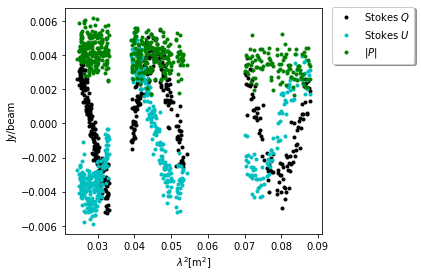

In [11]:
plt.plot(simsource.lambda2, simsource.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(simsource.lambda2, simsource.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(simsource.lambda2, np.abs(simsource.data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
plt.legend(loc=(1.04, 0.755), fancybox=True, shadow=True)
plt.tight_layout()

In [12]:
parameter = Parameter()

In [13]:
parameter.calculate_cellsize(dataset=simsource, oversampling=8)

FWHM of the main peak of the RMTF: 54.380 rad/m^2
Maximum recovered width structure: 129.664 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 13703.755


In [14]:
nufft = NUFFT1D(dataset=simsource, parameter=parameter, solve=True)

In [15]:
dft = DFT1D(dataset=simsource, parameter=parameter)

In [16]:
F_dirty = dft.backward(simsource.data)

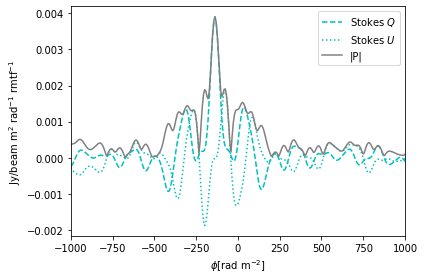

In [17]:
plt.plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_dirty), '-', c='grey', label=r"|P|")
#plt.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
#plt.plot(parameter.phi,np.zeros(len(parameter.phi)),ls='-',lw=2.,c='black')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000, 1000])
plt.tight_layout()

In [18]:
idx_noise = np.where(np.abs(parameter.phi) > parameter.max_faraday_depth * 0.8)
noise_F = 0.5 * (np.std(F_dirty[idx_noise].real) + np.std(F_dirty[idx_noise].imag))
noise_F * 1000.0

0.058736957726068795

In [19]:
wav = None
#wav = UndecimatedWavelet(wavelet_name="coif2")

In [20]:
lambda_l1 = np.sqrt(2 * simsource.m + np.sqrt(4 * simsource.m)) * theo_noise
#lambda_l1 = np.sqrt(dataset.m) * noise_F
#print(lambda_l1)
#lambda_l1 /= 2
#lambda_l1=0.5
lambda_tsv = 0.0
chi2 = Chi2(dft_obj=nufft, wavelet=wav)
l1 = L1(reg=lambda_l1)
tsv = TSV(reg=lambda_tsv)
# F_func = [chi2(P, dft, W), L1(lambda_l1)]
F_func = [chi2, l1, tsv]
f_func = [chi2]
g_func = [l1, tsv]

F_obj = OFunction(F_func)
f_obj = OFunction(f_func)
g_obj = OFunction(g_func)

In [21]:
parameter.data = F_dirty
parameter.complex_data_to_real()
if wav is not None:
    wav.calculate_max_level(parameter.data)
    parameter.data = wav.decompose(parameter.data)

In [22]:
opt = FISTA(guess_param=parameter, F_obj=F_obj, fx=chi2, gx=g_obj, noise=theo_noise, verbose=True)
#opt = FISTA(i_guess=F_real, F_obj=F_obj, fx=chi2, gx=g_obj, maxiter=1000, noise=1e-5, verbose=True)
obj, X = opt.run()

Iterations set to 32
Iteration:  0  objective function value: 4558.82938


In [23]:
if wav is not None:
    X.data = wav.reconstruct(X.data)
X.real_data_to_complex()

(-1000.0, 1000.0)

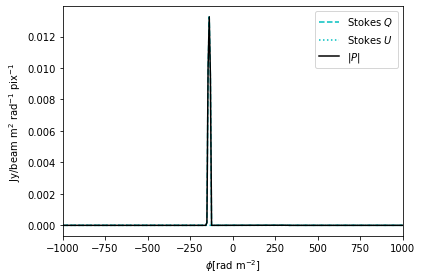

In [24]:
plt.plot(parameter.phi, X.data.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, X.data.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(X.data), 'k-', label=r"$|P|$")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim([-1000, 1000])

In [25]:
F_residual = dft.backward(simsource.residual)

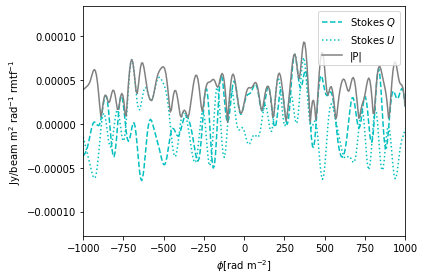

In [26]:
plt.plot(parameter.phi, F_residual.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_residual.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_residual), '-', c='grey', label=r"|P|")
#plt.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
#plt.plot(parameter.phi,np.zeros(len(parameter.phi)),ls='-',lw=2.,c='black')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000, 1000])
plt.tight_layout()

In [27]:
conv_model = X.convolve() + F_residual

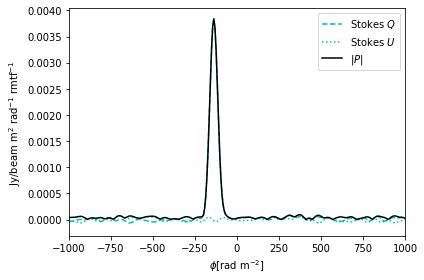

In [28]:
plt.plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(conv_model), 'k-', label=r"$|P|$")
#plt.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
#plt.plot(parameter.phi,np.zeros(len(parameter.phi)),ls='-',lw=2.,c='black')
plt.xlim([-1000, 1000])
#plt.axhline (y = 5*noise_F, color = 'b')
#plt.axhline (y = -5*noise_F, color = 'b')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()